(This notebook is for **the final** assignment of the **Coursera Applied Data Science Capstone** module.)
### Segementing and clustering analysis of Dublin, Ireland, with respect to housing prices

### 3.1.1 Get Dublin Postcodes and plot

(Section headings here follow that of the report submitted.)

In [1]:
# install web-scraper (following: https://youtu.be/ng2o98k983k)
#! pip install beautifulsoup4 # uncomment if not installed
#! pip install lxml # uncomment if not installed
#! pip intsall html5lib # uncomment if not installed
#! pip install requests # uncomment if not installed

Import libraries and get Wikipedia page content.

In [2]:
import pandas as pd # import pandas library
import requests # import requests library
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# use the inline backend to generate the plots within the browser
%matplotlib inline  

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.3


In [3]:
url='https://en.wikipedia.org/wiki/List_of_Dublin_postal_districts' # url to be scraped
page_response = requests.get(url) # fetch the url content using the requests library
src=page_response.content # set the content of the repsonse to a variable #https://realpython.com/python-requests/

Import the beautiful soup library, create the soup object and output the page title.

In [4]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(src, 'lxml') # pass the variable to BeautifulSoup, https://youtu.be/87Gx3U0BDlo                    
#print(soup)
soup.title.text # output the title of the soup object #https://www.pluralsight.com/guides/extracting-data-html-beautifulsoup

'List of Dublin postal districts - Wikipedia'

Create a variable for the table only. Find all the **tr** tagged data in the table.

In [5]:
table=soup.find("table",{"class":"wikitable"})  #https://stackoverflow.com/questions/33766740/beautifulsoup-find-table-with-specified-class-on-wikipedia-page
table_data = table.tbody.find_all("tr") # in the table body find all tr tags 
# uncomment a line to check the data
#print(table) 
#print(table.title) 
#print(table_data)

Get and print the table headings.

In [6]:
headings = []
for th in table_data[0].find_all("th"):
    headings.append(th.text.replace('\n',''))
headings[0]=headings[0].replace("'", '') # strip the apostrophe
#headings[2]='Neighborhood'
print(headings) # list of table headings

['Dublins postal districts']


Get the data from the table for one row to check it.

In [7]:
data_list = []
for td in table_data[7].find_all("td"):
    data_list.append(td.text.replace('\n',''))
print(data_list)

['Dublin 11 (D11) Dublin, Fingal', 'Dublin 10 (D10) Dublin']


Get the data from the table for all rows as a list.

In [8]:
data_list = [] # variable for list off all data we want
for i in range(2,len(table_data)-1):
    for td in table_data[i].find_all("td"): # finds all the td tags in the html
        data_list.append(td.text.replace('\n','')) # add the row to the list
print(data_list) # uncomment to check

['Dublin 1 (D1) Dublin', 'Dublin 2 (D2) Dublin', 'Dublin 3 (D3) Dublin', 'Dublin 4 (D4) Dublin, Dun Laoghaire Rathdown', 'Dublin 5 (D5) Dublin', 'Dublin 6 (D6) Dublin, Dún Laoghaire Rathdown', 'Dublin 7 (D7) Dublin', 'Dublin 6W (D6W) Dublin, South Dublin', 'Dublin 9 (D9) Dublin', 'Dublin 8 (D8) Dublin', 'Dublin 11 (D11) Dublin, Fingal', 'Dublin 10 (D10) Dublin', 'Dublin 13 (D13) Dublin, Fingal', 'Dublin 12 (D12) Dublin', 'Dublin 15 (D15) Fingal', 'Dublin 14 (D14) Dublin, Dún Laoghaire–Rathdown, South Dublin', 'Dublin 17 (D17) Dublin, Fingal', 'Dublin 16 (D16) Dún Laoghaire–Rathdown, South Dublin', '', 'Dublin 18 (D18) Dún Laoghaire–Rathdown', 'Dublin 20 (D20) Dublin, South Dublin', 'Dublin 22 (D22) South Dublin', 'Dublin 24 (D24) South Dublin']


Call the DataFrame() constructor on the list, assign the dataframe headings, remove NaNs, reset the index.

In [9]:
df=pd.DataFrame(data_list) # make the result a dataframe
df.columns=headings # assign the table headings as the column names
df['Dublins postal districts'].replace('', np.nan, inplace=True) # replace blank entries with NaN
df=df.dropna(subset=['Dublins postal districts']) # drop rows with NaN
df=df.reset_index() # reset the idnex of the dataframe
del df['index']
df.head()

,Dublins postal districts
0,Dublin 1 (D1) Dublin
1,Dublin 2 (D2) Dublin
2,Dublin 3 (D3) Dublin
3,"Dublin 4 (D4) Dublin, Dun Laoghaire Rathdown"
4,Dublin 5 (D5) Dublin


Build a new dataframe (**post_codes**) with only the first 8 characters of each row in **df**.

In [10]:
post_codes=[]
for row in range(0,len(df)):
    temp=df['Dublins postal districts'][row]
    post_codes.append(temp[0:9].strip()) # takes the first 10 characters only, removes 
post_codes=pd.DataFrame(post_codes, columns=df.columns)
post_codes.head()

,Dublins postal districts
0,Dublin 1
1,Dublin 2
2,Dublin 3
3,Dublin 4
4,Dublin 5


Instantiate new columns for latitude and longitude in **post_codes**.

In [11]:
post_codes['Latitude']=None
post_codes['Longitude']=None
post_codes.head()

,Dublins postal districts,Latitude,Longitude
0,Dublin 1,None,None
1,Dublin 2,None,None
2,Dublin 3,None,None
3,Dublin 4,None,None
4,Dublin 5,None,None


Use OpenCage Geocoding API (https://opencagedata.com/api) to get latitude and longitude

In [12]:
#!pip install opencage # uncomment if not isntalled
from opencage.geocoder import OpenCageGeocode
key = 'ffa8658ade93408d9d4b84e1becce415'
geocoder = OpenCageGeocode(key)

for i in range(len(df)):
    code=post_codes.loc[i]['Dublins postal districts']
    address = u'{}, Ireland'.format(code) # address to query
    results = geocoder.geocode(address)
    longitude = results[0]['geometry']['lng']
    latitude = results[0]['geometry']['lat']
    #print(address, latitude, longitude) # uncomment to check each result
    post_codes.loc[i]['Latitude']=latitude # assign latitude in dataframe
    post_codes.loc[i]['Longitude']=longitude # assign longitude in dataframe
post_codes

,Dublins postal districts,Latitude,Longitude
0,Dublin 1,53.3525,-6.25665
1,Dublin 2,53.3389,-6.25271
2,Dublin 3,53.3612,-6.18547
3,Dublin 4,53.3275,-6.22749
4,Dublin 5,53.3835,-6.18192
5,Dublin 6,53.3177,-6.25953
6,Dublin 7,53.3606,-6.28447
7,Dublin 6W,53.3093,-6.29943
8,Dublin 9,53.386,-6.24558
9,Dublin 8,53.3503,-6.32021


Create a map of Dublin with labelled circle markers 3 km in diameter for each district.

In [13]:
import folium # map rendering library
from folium.features import DivIcon
ref_latitude= post_codes.loc[10]['Latitude']  # map centre latitude
ref_longitude = post_codes.loc[10]['Longitude'] # map centre longitude
map_dublin = folium.Map(location=[ref_latitude, ref_longitude], zoom_start=11)

# add markers to map
#for lat, lng, borough, neighborhood in zip(postal_codes['Latitude'], postal_codes['Longitude'], postal_codes['Borough'], postal_codes['Neighborhood']):
for lat, lng , code in zip(post_codes['Latitude'], post_codes['Longitude'], post_codes['Dublins postal districts']):
    label = '{}'.format(code)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1500, # radius of marker in metres
        color='#3186cc', #'blue',
        popup=label,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.2,
        opacity=0.8,
        parse_html=False).add_to(map_dublin)
    folium.map.Marker( #https://github.com/python-visualization/folium/issues/340#issuecomment-179673692
        [lat, lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt"><b>'+'D'+code[-2:]+'</b></div>',
            )
        ).add_to(map_dublin)
    
map_dublin # display the map

### 3.1.2 Get Irish housing price dataset and filter for Dubin only addresses

In [14]:
import urllib.request
import os
#url = 'https://propertypriceregister.ie/website/npsra/ppr/npsra-ppr.nsf/Downloads/'
#filename = 'PPR-ALL.zip'
#urllib.request.urlretrieve(url, filename) # conda install -c anaconda certifi #https://github.com/ContinuumIO/anaconda-issues/issues/494

In [15]:
df_houses=pd.read_csv('PPR-ALL.csv', encoding = "ISO-8859-1") #https://stackoverflow.com/a/18172249
df_houses.head()

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",NaN,Dublin,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",NaN,Meath,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",NaN,Kilkenny,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


### 3.1.3 Data wrangling and exploratory data analysis of the Dublin housing dataset

#### First, wrangle the data

In [16]:
print(df_houses.dtypes) # print out the data types

Date of Sale (dd/mm/yyyy)    object
Address                      object
Postal Code                  object
County                       object
Price ()                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object


In [17]:
missing_data=df_houses.isnull() # dataframe of Booleans where data is missing
missing_data.head()

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,False,False,True,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,True


Use this list to summarise 'missing values' data (next)

In [18]:
missing_data.columns.values.tolist()

['Date of Sale (dd/mm/yyyy)',
 'Address',
 'Postal Code',
 'County',
 'Price (\x80)',
 'Not Full Market Price',
 'VAT Exclusive',
 'Description of Property',
 'Property Size Description']

Loop through to check for missing values.

In [19]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

Date of Sale (dd/mm/yyyy)
False    408419
Name: Date of Sale (dd/mm/yyyy), dtype: int64

Address
False    408419
Name: Address, dtype: int64

Postal Code
True     331998
False     76421
Name: Postal Code, dtype: int64

County
False    408419
Name: County, dtype: int64

Price ()
False    408419
Name: Price (), dtype: int64

Not Full Market Price
False    408419
Name: Not Full Market Price, dtype: int64

VAT Exclusive
False    408419
Name: VAT Exclusive, dtype: int64

Description of Property
False    408419
Name: Description of Property, dtype: int64

Property Size Description
True     355854
False     52565
Name: Property Size Description, dtype: int64



There are no house prices missing, but there are 331,998 post codes missing out of 408,419.

Filter the data frame for Dublin houses, drop unwanted columns, drop rows with missing postcodes or 'not full market price'

In [20]:
condition=df_houses['County']=='Dublin' # filter condition
df_houses_dublin=df_houses[condition] # define new dataframe by filter condition
df_houses_dublin=df_houses_dublin.drop(columns=['VAT Exclusive','Property Size Description','County']) # drop unwanterd columns
df_houses_dublin.replace('', np.nan, inplace = True) # replace and empty values witn NaNs
df_houses_dublin.dropna(subset=['Postal Code'], inplace = True) # drop all NaNs in postal code column
condition=df_houses_dublin['Not Full Market Price']=='No' # filter condition
df_houses_dublin=df_houses_dublin[condition] # define dataframe by filter condition
df_houses_dublin.drop(columns=['Not Full Market Price'], inplace = True) # drop unwanted column

In [21]:
# to remove houses with a 'Dublin' county but not a Dublin XX postcode'
condition=[]
for row in range(0,len(df_houses_dublin['Postal Code'])):
    temp=df_houses_dublin.iloc[row]['Postal Code']
    if temp[0:6]=='Dublin':
        condition.append(True)
    else:
        condition.append(False)
df_houses_dublin=df_houses_dublin[condition] # define dataframe by filter condition 72372

In [22]:
print(df_houses_dublin.shape) # print out cleaned dataframe shape

(72362, 5)


In [23]:
df_houses_dublin=df_houses_dublin.reset_index().drop(columns=['index']) # reset the index
df_houses_dublin.head() # output last five rows of cleaned dataframe to check

,Date of Sale (dd/mm/yyyy),Address,Postal Code,Price (),Description of Property
0,04/01/2010,"The Mews, 11A Wyckham Park Road, Dundrum",Dublin 14,"345,000.00",Second-Hand Dwelling house /Apartment
1,05/01/2010,"134 longboat quay north, sir john rogersons quay",Dublin 2,"225,000.00",New Dwelling house /Apartment
2,05/01/2010,"3 Myrtle Square, The Coast, Baldoyle",Dublin 13,"265,198.00",New Dwelling house /Apartment
3,05/01/2010,"87 MANGERTON RAOD, DRIMNAGH",Dublin 12,"182,556.12",Second-Hand Dwelling house /Apartment
4,05/01/2010,"9 Temple Manor Drive, Walkinstown, Dublin 12",Dublin 12,"300,000.00",Second-Hand Dwelling house /Apartment


Create a new column by looping through each element of the Price column, taking the price without the currency special character, then remove commas and decimal points and convert to 'float' type. Finally, add the column back to the dataframe and drop the old column with the special character.  

In [24]:
new_column=[] # empty list
for i in range(0,len(df_houses_dublin)):
    temp=df_houses_dublin.iloc[i]['Price (\x80)']
    temp=temp[1:].replace(',','').replace('.','') # drop the first element, remove commas and decimal points
    temp=float(temp)/100 # covert to float type and euro
    new_column.append(temp) # add to the new column list
df_houses_dublin['Price']=new_column # add the columm to the dataframe
df_houses_dublin=df_houses_dublin.drop(columns=['Price (\x80)']) # drop the unwanted column
df_houses_dublin.head() # print out the first five rows to check

,Date of Sale (dd/mm/yyyy),Address,Postal Code,Description of Property,Price
0,04/01/2010,"The Mews, 11A Wyckham Park Road, Dundrum",Dublin 14,Second-Hand Dwelling house /Apartment,345000.00
1,05/01/2010,"134 longboat quay north, sir john rogersons quay",Dublin 2,New Dwelling house /Apartment,225000.00
2,05/01/2010,"3 Myrtle Square, The Coast, Baldoyle",Dublin 13,New Dwelling house /Apartment,265198.00
3,05/01/2010,"87 MANGERTON RAOD, DRIMNAGH",Dublin 12,Second-Hand Dwelling house /Apartment,182556.12
4,05/01/2010,"9 Temple Manor Drive, Walkinstown, Dublin 12",Dublin 12,Second-Hand Dwelling house /Apartment,300000.00


Check the shape of the dateframe and data types.

In [25]:
print(df_houses_dublin.shape)
df_houses_dublin.dtypes

(72362, 5)


Date of Sale (dd/mm/yyyy)     object
Address                       object
Postal Code                   object
Description of Property       object
Price                        float64
dtype: object

#### Next, explore the dataset.

In [26]:
df_houses_dublin.describe()

,Price
count,7.236200e+04
mean,4.079025e+05
std,1.326552e+06
min,5.250000e+03
25%,2.120000e+05
50%,2.990000e+05
75%,4.280000e+05
max,1.422566e+08


In [27]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_houses_dublin['Price'])
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[72318    19     9     4     7     2     1     0     0     2]
[5.25000000e+03 1.42303826e+07 2.84555152e+07 4.26806478e+07
 5.69057804e+07 7.11309130e+07 8.53560456e+07 9.95811782e+07
 1.13806311e+08 1.28031443e+08 1.42256576e+08]


Clearly there are some very large outliers in the data set since the vast majority of houses 72,328 out of 72,372 are in the first bin (<1.4m). This is illustrated by applying the histogram plot to the data.

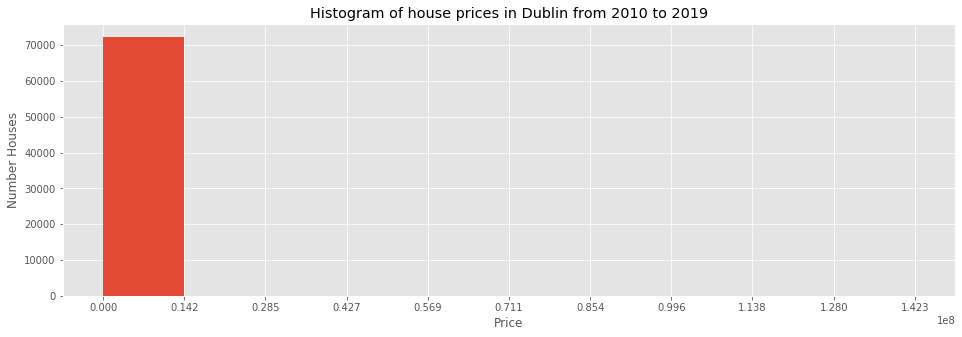

In [28]:
df_houses_dublin['Price'].plot(kind='hist', figsize=(16, 5), xticks=bin_edges)

plt.title('Histogram of house prices in Dublin from 2010 to 2019') # add a title to the histogram
plt.ylabel('Number Houses') # add y-label
plt.xlabel('Price') # add x-label

plt.show()

In [29]:
price_array=np.array(df_houses_dublin['Price'])
mu=np.mean(price_array)
sd=np.std(price_array)
print('Mean house price in Dublin (2010-2019): \u20ac',round(mu)) #https://stackoverflow.com/a/39935897
print('Standard deviation of house prices in Dublin (2010-2019): \u20ac',round(sd))

Mean house price in Dublin (2010-2019): € 407902.0
Standard deviation of house prices in Dublin (2010-2019): € 1326543.0


So remove the outliers to plot a graph of realistic data for Dublin. 

In [30]:
n_sigmas = 2
upper = mu + n_sigmas*sd
lower = mu - n_sigmas*sd
condition=df_houses_dublin['Price']<upper #& df_houses_dublin['Price']>lower # filter condition #https://stackoverflow.com/a/36922103
df_houses_dublin=df_houses_dublin[condition] # define new dataframe by filter condition
#https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

In [31]:
print('Upper limit for outliers: \u20ac',round(upper))

Upper limit for outliers: € 3060989.0


Try the hist plot again without the outliers.

[72318    19     9     4     7     2     1     0     0     2]
[5.25000000e+03 1.42303826e+07 2.84555152e+07 4.26806478e+07
 5.69057804e+07 7.11309130e+07 8.53560456e+07 9.95811782e+07
 1.13806311e+08 1.28031443e+08 1.42256576e+08]


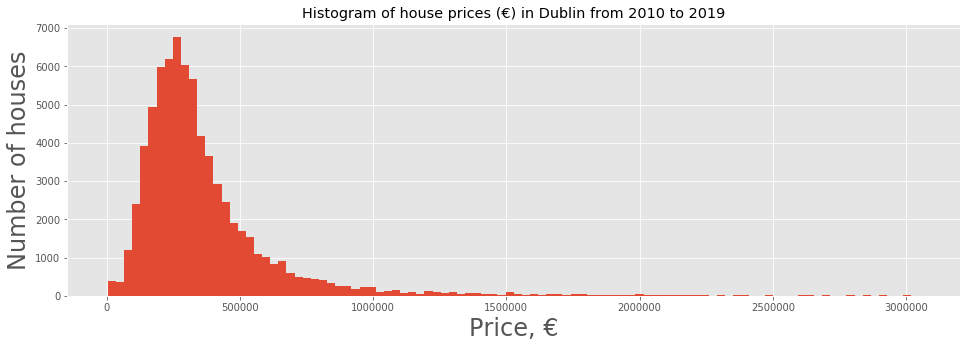

In [32]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(price_array)
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

df_houses_dublin['Price'].plot(kind='hist', figsize=(16, 5), bins=100) #xticks=bin_edges)

plt.title("Histogram of house prices (\u20ac) in Dublin from 2010 to 2019") # add a title to the histogram
plt.ylabel('Number of houses', fontdict={'fontsize': 24}) # add y-label
plt.xlabel('Price, \u20ac', fontdict={'fontsize': 24}) # add x-label

plt.show()

Create a box plot with the x-axis given by Postal Code.

Text(0.5, 1.0, 'Box plot of house prices (€) by Dublin postal code from 2010 to 2019')

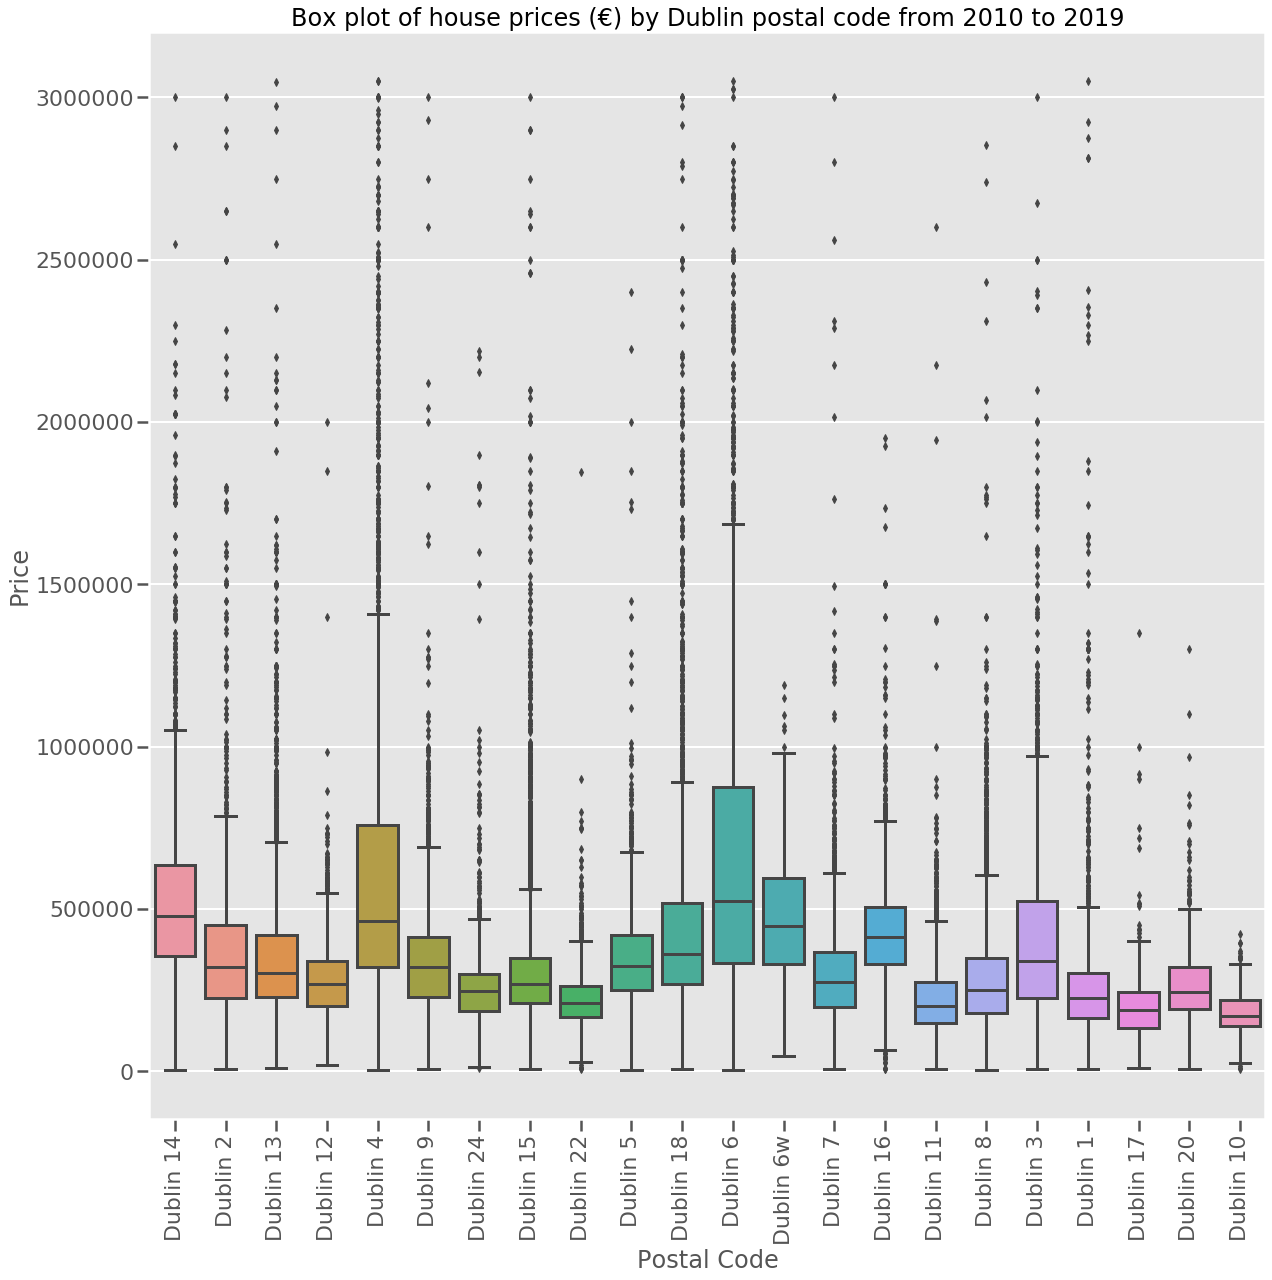

In [76]:
sns.set_context("poster") 
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(x="Postal Code", y="Price", data=df_houses_dublin, ax=ax) #https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib
ax.set_title('Box plot of house prices (\u20ac) by Dublin postal code from 2010 to 2019')

Box plots show the high standard deviation in price.

Group the dataframe by postcode and plot in descending mean value.

Text(0, 0.5, 'Mean price, €')

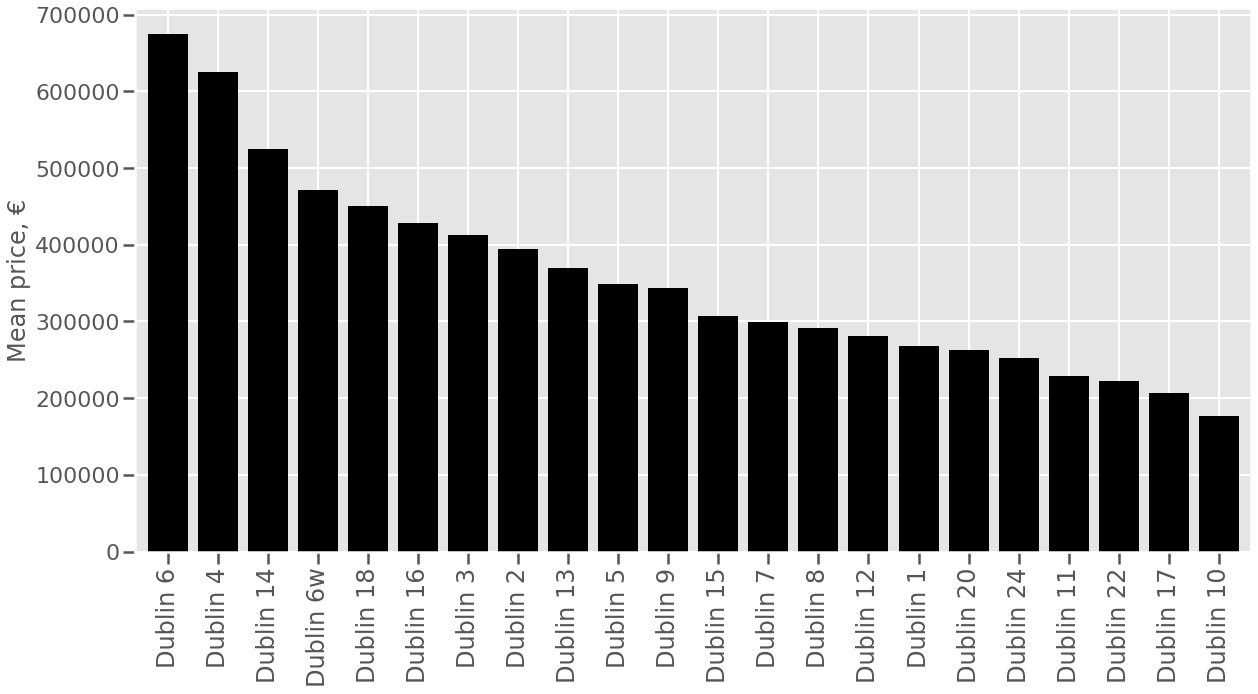

In [77]:
df_houses_dublin_grouped = df_houses_dublin.groupby('Postal Code').mean().reset_index().sort_values(by='Price',ascending=False)

ax = df_houses_dublin_grouped.plot(kind='bar', width=0.8, figsize=(20, 10), legend=None, color = 'k') #,color=['#5cb85c','#5bc0de','#d9534f'])
ax.set_xticklabels(list(df_houses_dublin_grouped['Postal Code']),fontdict={'fontsize': 24}) # https://stackoverflow.com/a/46651121
ax.set_ylabel('Mean price, \u20ac') # add y-label

In [78]:
#Could consider adjusting value for consumer proce index and inflation:
#https://tradingeconomics.com/ireland/consumer-price-index-cpi 'cpi.csv'
#https://towardsdatascience.com/the-what-and-why-of-inflation-adjustment-5eedb496e080

## 3.2 Location data by parish

### Get the Parish geodata Dublin Parishes

Identify current path.

In [79]:
from pathlib import Path 
mypath = Path().absolute() #https://stackoverflow.com/a/50098973
mypath

WindowsPath('C:/Users/robin.mooney/git_projects/Coursera_Capstone')

Get Dublin Parishes data from townlands.ie

In [80]:
import urllib.request
import os
url = 'https://www.townlands.ie/static/downloads/'
filename = 'civil_parishes.geojson.zip'
urllib.request.urlretrieve(url, filename)

('civil_parishes.geojson.zip', <http.client.HTTPMessage at 0x1d9e1807a90>)

In [81]:
#filename_new = 'civil_parishes.zip'
#path_file_new = mypath / filename_new # https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
#os.rename(path_file, filename_new)

#path_file_new = mypath / filename_new # https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
#path_file_new

#import zipfile
#with zipfile.ZipFile(filename_new, 'r') as zip_ref:
#    zip_ref.extractall(mypath)

Build path and file name to open.

In [82]:
path_file = mypath / filename # https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f
path_file

WindowsPath('C:/Users/robin.mooney/git_projects/Coursera_Capstone/civil_parishes.geojson.zip')

In [83]:
import folium
dublin_geo = r'civil_parishes.geojson' # geojson file
# create a plain dublin map
map_parishes = folium.Map(location=[ref_latitude, ref_longitude], zoom_start=10)#, tiles='Stamen Terrain')
map_parishes

Open parishes geojson file and print out all parish names in Dublin.

In [84]:
import json # https://gis.stackexchange.com/a/73771

with open('civil_parishes.geojson',encoding="utf8") as f: #https://stackoverflow.com/a/9233174
    data = json.load(f)
    
i=0
for feature in data['features']:
    if feature['properties']['CO_NAMES']=='Dublin':
        print (feature['properties']['NAME_EN'])
        i=i+1
        #data_dublin[feature['properties']['NAME_EN']]
print('Number of parishes in Dublin: ',i)

Saggart
Clondalkin
Esker
Tallaght
Clonsilla
Mulhuddart
Finglas
Cruagh
Naul
Santry
Whitechurch
St. Peter's
Swords
Balscaddan
Taney
Lusk
Balrothery
Clontarf
Monkstown
Rathmichael
Portraine
Ben of Howth
Newcastle
Rathcoole
Kilmactalway
Aderrig
Lucan
Kilbride
Kilmactalway
Ballymadun
Garristown
Palmerston
Castleknock
Ballyfermot
Cloghran
Ward
Palmerstown
Drimnagh
Kilsallaghan
Chapelizod
Clonmethan
St. Jude's
Crumlin
Grallagh
St. Margaret's
Rathfarnham
Hollywood
St. James's
Westpalstown
Killossery
Grangegorman
Killeek
St. Catherine's
Glasnevin
Ballyboghil
St. Nicholas' Without
St. George's
Kiltiernan
Kilgobbin
Clonturk
St. Mark's
Donnybrook
Cloghran
Artane
Coolock
Baldongan
Kilmacud
Tully
Killester
Balgriffin
Kinsaley
Kill
Booterstown
Stillorgan
Donabate
Raheny
Malahide
Kilbarrack
Holmpatrick
Baldoyle
Portmarnock
Killiney
Dalkey
Number of parishes in Dublin:  83


Construct a dataframe with the parish name , county, latitude and longitude of each parish.

In [89]:
df_dublin=[]
i=0
df_dublin=pd.DataFrame(columns=['Parish', 'County', 'Lat', 'Lon'])
for feature in data['features']: #https://stackoverflow.com/questions/3294889/iterating-over-dictionaries-using-for-loops
    if feature['properties']['CO_NAMES']=='Dublin':
        #print(feature['properties']['NAME_EN'],feature['properties']['LATITUDE'],feature['properties']['LONGITUDE'])
        county=feature['properties']['CO_NAMES']
        parish=feature['properties']['NAME_EN']
        lat=feature['properties']['LATITUDE']
        long=feature['properties']['LONGITUDE']
        df_dublin.loc[i]= [ parish, county, str(lat), str(long)] #https://stackoverflow.com/a/25376997
        i=i+1
        #dubin_parish_geodata=feature['geometry']['coordinates']
#dubin_parish_geodata.keys()
df_dublin['Lat'].astype('float') # cast type as float
df_dublin['Lon'].astype('float') # cast type as float
df_dublin.head() # display first 5 rows

,Parish,County,Lat,Lon
0,Saggart,Dublin,53.2712997522548,-6.44658461901325
1,Clondalkin,Dublin,53.3208467532723,-6.40117914862287
2,Esker,Dublin,53.348266197028,-6.43190148472551
3,Tallaght,Dublin,53.2499328186383,-6.36782245174626
4,Clonsilla,Dublin,53.3862105365963,-6.41927383372194


In [90]:
#df_dublin.Lat.astype(float).dtypes
df_dublin.shape # resulting dataframe shape

(83, 4)

In [91]:
# instantiate a feature group for the incidents in the dataframe
parishes = folium.map.FeatureGroup()

# loop through parishes and add each one to the feature group
for lat, lng, in zip(df_dublin.Lat.astype(float), df_dublin.Lon.astype(float)):
    parishes.add_child(
        folium.features.CircleMarker(
        #folium.features.Circle(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
map_parishes.add_child(parishes)

### Use Foursquare to get recommendations in all Dublin parishes.

Define Foursquare credentials and version.

In [92]:
CLIENT_ID = 'EIFEZ4ZQWKUH2DGAR45JXJB4RGZ34X5FQM3O5O2041VCP4Y5' # Foursquare ID
CLIENT_SECRET = '4QI3EVAC5L3REJPYSUD2BRSKOGZYNBTUJVO4121XMVLK5XVL' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: EIFEZ4ZQWKUH2DGAR45JXJB4RGZ34X5FQM3O5O2041VCP4Y5
CLIENT_SECRET:4QI3EVAC5L3REJPYSUD2BRSKOGZYNBTUJVO4121XMVLK5XVL


Pick an example parish to check the API results.

In [93]:
df_dublin.loc[0] # example parish

Parish              Saggart
County               Dublin
Lat        53.2712997522548
Lon       -6.44658461901325
Name: 0, dtype: object

In [94]:
neighborhood_latitude = df_dublin.loc[0, 'Lat'] # latitude value
neighborhood_longitude = df_dublin.loc[0, 'Lon'] # longitude value

neighborhood_name = df_dublin.loc[0, 'Parish'] # neighborhood name

print('Latitude and longitude values of {} are {} and {}, respectively.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Saggart are 53.2712997522548 and -6.44658461901325, respectively.


#### Get the top 100 venues that in thats parish within a set radius.

First create the GET request URL

In [95]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=EIFEZ4ZQWKUH2DGAR45JXJB4RGZ34X5FQM3O5O2041VCP4Y5&client_secret=4QI3EVAC5L3REJPYSUD2BRSKOGZYNBTUJVO4121XMVLK5XVL&v=20180605&ll=53.2712997522548,-6.44658461901325&radius=1500&limit=100'

Send the request and display the result

In [96]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e441882923935001b0300fe'},
 'response': {'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 53.28479976575481,
    'lng': -6.424052501969914},
   'sw': {'lat': 53.257799738754784, 'lng': -6.469116736056586}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b92ab4bf964a5209a0f34e3',
       'name': 'Anvil Restaurant',
       'location': {'address': 'Garters Ln',
        'lat': 53.280976572880036,
        'lng': -6.443511203395441,
        'labeledLatLngs': [{'label': 'display',
          'lat': 53.280976572880036,
          'lng': -6.443511203395441}],
        'distance': 1096,
        'cc': 'IE',
        '

The items key has the information we want. Define a function that extracts the category from the items key.

In [97]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure into a Pandas dataframe.

In [98]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
venues = results['response']['groups'][0]['items']
#venues[0]
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

C:\Users\robin.mooney\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet
0,e-0-4b92ab4bf964a5209a0f34e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4b92ab4bf964a5209a0f34e3,Anvil Restaurant,Garters Ln,53.280977,-6.443511,"[{'label': 'display', 'lat': 53.28097657288003...",1096,IE,Saggart,Ireland,"[Garters Ln, Saggart, Ireland]","[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",0,[],NaN
1,e-0-4ccafd22ba79a1cd827131cb-1,0,"[{'summary': 'This spot is popular', 'type': '...",4ccafd22ba79a1cd827131cb,Dunnes Stores,"Slade Castle, Botherboy Rd",53.279119,-6.446794,"[{'label': 'display', 'lat': 53.27911867881888...",870,IE,Saggart,Ireland,"[Slade Castle, Botherboy Rd, Saggart, Ireland]","[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",0,[],NaN
2,e-0-4d01e79f02d0a35d77f79b7e-2,0,"[{'summary': 'This spot is popular', 'type': '...",4d01e79f02d0a35d77f79b7e,Centra,Main St,53.279113,-6.446824,"[{'label': 'display', 'lat': 53.27911310956659...",869,IE,Saggart,Ireland,"[Main St, Saggart, Ireland]","[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",0,[],NaN
3,e-0-4d2f4fced9d8a143861102d8-3,0,"[{'summary': 'This spot is popular', 'type': '...",4d2f4fced9d8a143861102d8,Saggart Pharmacy,Mill Rd,53.279424,-6.445194,"[{'label': 'display', 'lat': 53.2794237008323,...",909,IE,Saggart,Ireland,"[Mill Rd, Saggart, Ireland]","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],NaN
4,e-0-4d6af301055a88bff55352cf-4,0,"[{'summary': 'This spot is popular', 'type': '...",4d6af301055a88bff55352cf,China Garden Restaurant,Garters Ln,53.280329,-6.444726,"[{'label': 'display', 'lat': 53.28032881395956...",1012,IE,Saggart,Ireland,"[Garters Ln (Above Jacobs Pub), Saggart, Ireland]","[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",0,[],Above Jacobs Pub


In [99]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Anvil Restaurant,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",53.280977,-6.443511
1,Dunnes Stores,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",53.279119,-6.446794
2,Centra,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",53.279113,-6.446824
3,Saggart Pharmacy,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",53.279424,-6.445194
4,China Garden Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",53.280329,-6.444726


In [100]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Anvil Restaurant,Restaurant,53.280977,-6.443511
1,Dunnes Stores,Supermarket,53.279119,-6.446794
2,Centra,Grocery Store,53.279113,-6.446824
3,Saggart Pharmacy,Pharmacy,53.279424,-6.445194
4,China Garden Restaurant,Chinese Restaurant,53.280329,-6.444726


In [101]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


## Explore the Parishes in Dublin

#### Create a function to repeat the same process for all the Neighborhoods in Dublin.

In [102]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Code to run the above function on each parish and create a new dataframe called *dublin_venues*.

In [103]:
dublin_venues = getNearbyVenues(names=df_dublin['Parish'],
                                   latitudes=df_dublin['Lat'],
                                   longitudes=df_dublin['Lon']
                                  )

Saggart
Clondalkin
Esker
Tallaght
Clonsilla
Mulhuddart
Finglas
Cruagh
Naul
Santry
Whitechurch
St. Peter's
Swords
Balscaddan
Taney
Lusk
Balrothery
Clontarf
Monkstown
Rathmichael
Portraine
Ben of Howth
Newcastle
Rathcoole
Kilmactalway
Aderrig
Lucan
Kilbride
Kilmactalway
Ballymadun
Garristown
Palmerston
Castleknock
Ballyfermot
Cloghran
Ward
Palmerstown
Drimnagh
Kilsallaghan
Chapelizod
Clonmethan
St. Jude's
Crumlin
Grallagh
St. Margaret's
Rathfarnham
Hollywood
St. James's
Westpalstown
Killossery
Grangegorman
Killeek
St. Catherine's
Glasnevin
Ballyboghil
St. Nicholas' Without
St. George's
Kiltiernan
Kilgobbin
Clonturk
St. Mark's
Donnybrook
Cloghran
Artane
Coolock
Baldongan
Kilmacud
Tully
Killester
Balgriffin
Kinsaley
Kill
Booterstown
Stillorgan
Donabate
Raheny
Malahide
Kilbarrack
Holmpatrick
Baldoyle
Portmarnock
Killiney
Dalkey


Check the size of the resuting dataframe.

In [104]:
print(dublin_venues.shape)
dublin_venues.head()

(2151, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Saggart,53.2712997522548,-6.44658461901325,Anvil Restaurant,53.280977,-6.443511,Restaurant
1,Saggart,53.2712997522548,-6.44658461901325,Dunnes Stores,53.279119,-6.446794,Supermarket
2,Saggart,53.2712997522548,-6.44658461901325,Centra,53.279113,-6.446824,Grocery Store
3,Saggart,53.2712997522548,-6.44658461901325,Saggart Pharmacy,53.279424,-6.445194,Pharmacy
4,Saggart,53.2712997522548,-6.44658461901325,China Garden Restaurant,53.280329,-6.444726,Chinese Restaurant


Check how many venues were returned for each neighborhood.

In [105]:
dublin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aderrig,4,4,4,4,4,4
Artane,42,42,42,42,42,42
Baldongan,3,3,3,3,3,3
Baldoyle,12,12,12,12,12,12
Balgriffin,20,20,20,20,20,20
...,...,...,...,...,...,...
Taney,62,62,62,62,62,62
Tully,40,40,40,40,40,40
Ward,5,5,5,5,5,5


#### Number of unique categories can be curated from all the returned venues

In [106]:
print('There are {} uniques categories.'.format(len(dublin_venues['Venue Category'].unique())))

There are 217 uniques categories.


## Analyse each Neighborhood

In [107]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head()

,Neighborhood,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Saggart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Saggart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Saggart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Saggart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Saggart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


New dataframe size.

In [108]:
dublin_onehot.shape

(2151, 218)

#### Group rows by Neighborhood and by taking the mean of the frequency of occurrence of each category.

In [109]:
dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aderrig,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0
1,Artane,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0
2,Baldongan,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0
3,Baldoyle,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0
4,Balgriffin,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.05,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Taney,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.016129,0.00,0.0,0.0
76,Tully,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.025,0.025,0.0,0.000000,0.00,0.0,0.0
77,Ward,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0
78,Westpalstown,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.00,0.0,0.0


New dataframe size:

In [110]:
dublin_grouped.shape

(80, 218)

#### Print each neighborhood along with the top 10 most common venues

In [111]:
num_top_venues = 10

for hood in dublin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dublin_grouped[dublin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aderrig----
                  venue  freq
0               Airport  0.25
1                 Hotel  0.25
2             Gastropub  0.25
3         Train Station  0.25
4             Pet Store  0.00
5       Nature Preserve  0.00
6             Nightclub  0.00
7          Noodle House  0.00
8          Optical Shop  0.00
9  Other Great Outdoors  0.00


----Artane----
                  venue  freq
0           Supermarket  0.12
1              Bus Stop  0.12
2  Fast Food Restaurant  0.10
3         Grocery Store  0.07
4    Chinese Restaurant  0.07
5                  Park  0.05
6                   Pub  0.05
7           Pizza Place  0.05
8                  Café  0.05
9    Italian Restaurant  0.02


----Baldongan----
                  venue  freq
0        Cricket Ground  0.33
1             Racetrack  0.33
2           Golf Course  0.33
3              Pharmacy  0.00
4             Nightclub  0.00
5          Noodle House  0.00
6          Optical Shop  0.00
7  Other Great Outdoors  0.00
8     Outdoor Scu

9  Fast Food Restaurant  0.04


----Hollywood----
                  venue  freq
0             Gun Range   1.0
1               Airport   0.0
2             Pet Store   0.0
3       Nature Preserve   0.0
4             Nightclub   0.0
5          Noodle House   0.0
6          Optical Shop   0.0
7  Other Great Outdoors   0.0
8     Outdoor Sculpture   0.0
9  Outdoor Supply Store   0.0


----Holmpatrick----
                venue  freq
0                 Bar  0.20
1       Grocery Store  0.13
2            Windmill  0.13
3       Train Station  0.07
4           Cafeteria  0.07
5         Supermarket  0.07
6           Gift Shop  0.07
7                Café  0.07
8  Seafood Restaurant  0.07
9              Castle  0.07


----Kilbarrack----
                  venue  freq
0           Supermarket  0.20
1         Train Station  0.20
2          Burger Joint  0.13
3         Grocery Store  0.07
4                   Bar  0.07
5       Badminton Court  0.07
6  Fast Food Restaurant  0.07
7         Shopping Mall  0.07

9             Pet Store  0.00


----Saggart----
                  venue  freq
0    Chinese Restaurant   0.2
1              Pharmacy   0.2
2           Supermarket   0.2
3            Restaurant   0.2
4         Grocery Store   0.2
5             Nightclub   0.0
6          Noodle House   0.0
7          Optical Shop   0.0
8  Other Great Outdoors   0.0
9     Outdoor Sculpture   0.0


----Santry----
                    venue  freq
0                   Hotel  0.16
1             Supermarket  0.08
2            Soccer Field  0.08
3     Rental Car Location  0.04
4             Fish Market  0.04
5                    Café  0.04
6  Furniture / Home Store  0.04
7           Go Kart Track  0.04
8                    Park  0.04
9              Food Court  0.04


----St. Catherine's----
                       venue  freq
0                       Café  0.12
1                        Pub  0.12
2                Coffee Shop  0.09
3                 Restaurant  0.08
4                    Brewery  0.04
5                

#### Put that into a *pandas* dataframe

First, write a function to sort the venues in descending order.

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [113]:
num_top_venues = 10 #10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
#neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aderrig,Airport,Train Station,Gastropub,Hotel,History Museum,English Restaurant,Food Court,Food & Drink Shop,Flea Market,Fish Market
1,Artane,Supermarket,Bus Stop,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Café,Pizza Place,Park,Pub,Coffee Shop
2,Baldongan,Racetrack,Cricket Ground,Golf Course,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market
3,Baldoyle,Train Station,Supermarket,Bar,Badminton Court,Park,Gastropub,Fast Food Restaurant,Pub,Convenience Store,Shopping Mall
4,Balgriffin,Coffee Shop,Pet Store,Hotel Bar,Fast Food Restaurant,Shopping Mall,Mobile Phone Shop,Supermarket,Garden Center,Bakery,Video Game Store


## 3.2 Machine learning model

### Cluster the Neighborhoods

Run k-means to cluster the neighborhood into clusters.

In [114]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

dublin_grouped_clustering = dublin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dublin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([9, 0, 8, 0, 0, 9, 0, 5, 9, 2, 9, 9, 9, 9, 9, 0, 1, 0, 9, 9, 0, 9,
       0, 9, 0, 9, 0, 0, 0, 4, 9, 9, 3, 0, 0, 8, 9, 0, 9, 0, 9, 9, 9, 9,
       8, 8, 9, 9, 0, 9, 9, 0, 8, 0, 0, 6, 0, 5, 9, 8, 0, 0, 0, 9, 9, 9,
       9, 9, 7, 9, 9, 9, 0, 0, 8, 9, 9, 9, 1, 9])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [115]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aderrig,Airport,Train Station,Gastropub,Hotel,History Museum,English Restaurant,Food Court,Food & Drink Shop,Flea Market,Fish Market
1,Artane,Supermarket,Bus Stop,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Café,Pizza Place,Park,Pub,Coffee Shop
2,Baldongan,Racetrack,Cricket Ground,Golf Course,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market
3,Baldoyle,Train Station,Supermarket,Bar,Badminton Court,Park,Gastropub,Fast Food Restaurant,Pub,Convenience Store,Shopping Mall
4,Balgriffin,Coffee Shop,Pet Store,Hotel Bar,Fast Food Restaurant,Shopping Mall,Mobile Phone Shop,Supermarket,Garden Center,Bakery,Video Game Store


In [116]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dublin_merged = df_dublin

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dublin_merged = dublin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Parish')

#dublin_merged.head() # check the last columns!
dublin_merged.dropna(inplace=True) 
dublin_merged.head()

,Parish,County,Lat,Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Saggart,Dublin,53.2712997522548,-6.44658461901325,0.0,Supermarket,Restaurant,Pharmacy,Chinese Restaurant,Grocery Store,Zoo Exhibit,Factory,Food Court,Food & Drink Shop,Flea Market
1,Clondalkin,Dublin,53.3208467532723,-6.40117914862287,0.0,Convenience Store,Bar,Hotel,Fast Food Restaurant,Chinese Restaurant,Supermarket,Coffee Shop,Restaurant,Canal Lock,Italian Restaurant
2,Esker,Dublin,53.348266197028,-6.43190148472551,0.0,Fast Food Restaurant,Supermarket,Bus Stop,Hockey Arena,Liquor Store,Pizza Place,Pharmacy,Coffee Shop,Park,Sandwich Place
3,Tallaght,Dublin,53.2499328186383,-6.36782245174626,8.0,Golf Course,Trail,Auto Workshop,Pet Store,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market
4,Clonsilla,Dublin,53.3862105365963,-6.41927383372194,0.0,Park,Grocery Store,Train Station,Platform,Fish & Chips Shop,Bus Stop,Falafel Restaurant,Golf Course,Liquor Store,Electronics Store


Finally, let's visualize the resulting clusters.

In [117]:
dublin_merged['Lat'].astype('float') # cast as float
dublin_merged['Lon'].astype('float') # cast as type
dublin_merged.tail()

,Parish,County,Lat,Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,Holmpatrick,Dublin,53.5731450179269,-6.12556767243118,0.0,Bar,Grocery Store,Windmill,Castle,Cafeteria,Gift Shop,Café,Seafood Restaurant,Train Station,Supermarket
79,Baldoyle,Dublin,53.4018467082392,-6.14591518622169,0.0,Train Station,Supermarket,Bar,Badminton Court,Park,Gastropub,Fast Food Restaurant,Pub,Convenience Store,Shopping Mall
80,Portmarnock,Dublin,53.424707648192,-6.13550103981727,0.0,Hotel,Fast Food Restaurant,Train Station,Nightclub,Bar,Golf Course,Supermarket,Italian Restaurant,Grocery Store,Steakhouse
81,Killiney,Dublin,53.2537444892101,-6.13107874664484,9.0,Convenience Store,Café,Coffee Shop,Historic Site,Light Rail Station,Bus Stop,Business Service,Food Truck,Supermarket,Sandwich Place
82,Dalkey,Dublin,53.2743145995537,-6.10398002622193,9.0,Pub,Restaurant,Café,Scenic Lookout,Chinese Restaurant,Italian Restaurant,Steakhouse,Beach,Sports Club,Bakery


In [123]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[ref_latitude, ref_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dublin_merged['Lat'].astype(float), dublin_merged['Lon'].astype(float), dublin_merged['Parish'], dublin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [129]:
#ref_latitude= post_codes.loc[10]['Latitude']  # map centre latitude
#ref_longitude = post_codes.loc[10]['Longitude'] # map centre longitude
#map_dublin = folium.Map(location=[ref_latitude, ref_longitude], zoom_start=11)

# add markers to map
#for lat, lng, borough, neighborhood in zip(postal_codes['Latitude'], postal_codes['Longitude'], postal_codes['Borough'], postal_codes['Neighborhood']):
for lat, lng , code in zip(post_codes['Latitude'], post_codes['Longitude'], post_codes['Dublins postal districts']):
    label = '{}'.format(code)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1500, # radius of marker in metres
        color='#3186cc', #'blue',
        popup=label,
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.2,
        opacity=0.8,
        parse_html=False).add_to(map_clusters)
    folium.map.Marker( #https://github.com/python-visualization/folium/issues/340#issuecomment-179673692
        [lat, lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt"><b>'+'D'+code[-2:]+'</b></div>',
            )
        ).add_to(map_clusters)
    
map_clusters # display the map

In [125]:
df_houses_dublin_grouped

,Postal Code,Price
17,Dublin 6,674867.625292
15,Dublin 4,624943.029586
5,Dublin 14,525388.704788
18,Dublin 6w,471329.236536
9,Dublin 18,449929.181612
7,Dublin 16,427741.936912
14,Dublin 3,412526.640148
10,Dublin 2,394472.057215
4,Dublin 13,369890.047245
16,Dublin 5,348934.200508


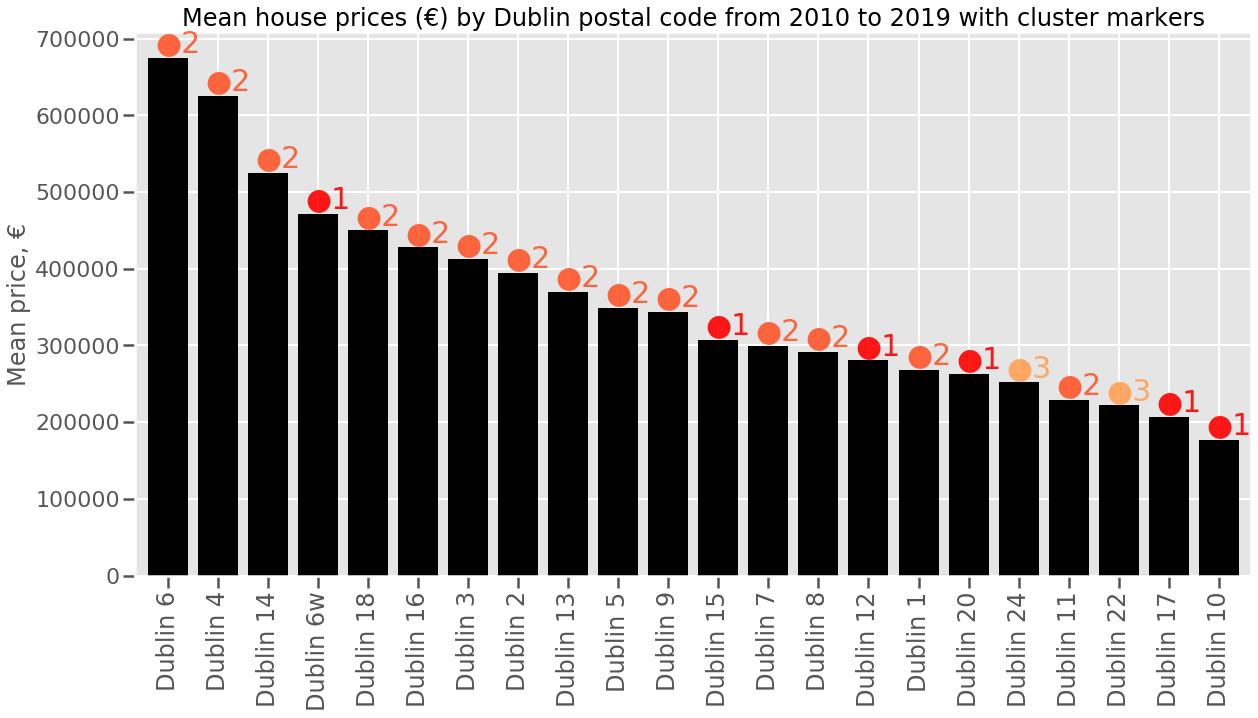

In [151]:
ax = df_houses_dublin_grouped.plot(kind='bar', width=0.8, figsize=(20, 10), legend=None, color='k') #,color=['#5cb85c','#5bc0de','#d9534f'])
ax.set_xticklabels(list(df_houses_dublin_grouped['Postal Code']),fontdict={'fontsize': 24}) # https://stackoverflow.com/a/46651121
ax.set_ylabel('Mean price, \u20ac') # add y-label
ax.set_title("Mean house prices (\u20ac) by Dublin postal code from 2010 to 2019 with cluster markers")
for index, value in enumerate(df_houses_dublin_grouped.iloc[:,1]):
    post=df_houses_dublin_grouped.iloc[index,0]
    #print(index, value, post)
    if post=='Dublin 2' or post=='Dublin 4' or post=='Dublin 6' or post=='Dublin 3' or post=='Dublin 5' or post=='Dublin 14' or post=='Dublin 16' or post=='Dublin 18':
        color=rainbow[8] # orange
        clust='2'
    elif post=='Dublin 1' or post=='Dublin 7' or post=='Dublin 8' or post=='Dublin 9' or post=='Dublin 11' or post=='Dublin 13':
        color=rainbow[8] # orange
        clust='2'
    elif post=='Dublin 6w' or post== 'Dublin 12'or post== 'Dublin 10' or post== 'Dublin 20' or post== 'Dublin 15' or post=='Dublin 17':
        color=rainbow[9] # red
        clust='1'
    elif post=='Dublin 22' or post== 'Dublin 24':
        color=rainbow[7] # yellow-orange
        clust='3'
    ax.annotate('\u25CF'+clust, xy=(index+0.2,value), color=color, alpha=0.9, fontsize=30, ha='center', va='bottom')

### Examine Clusters

#### Cluster 0 (RED) ('Cluster 1' in the report)

In [147]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 0, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Saggart,Supermarket,Restaurant,Pharmacy,Chinese Restaurant,Grocery Store,Zoo Exhibit,Factory,Food Court,Food & Drink Shop,Flea Market
1,Clondalkin,Convenience Store,Bar,Hotel,Fast Food Restaurant,Chinese Restaurant,Supermarket,Coffee Shop,Restaurant,Canal Lock,Italian Restaurant
2,Esker,Fast Food Restaurant,Supermarket,Bus Stop,Hockey Arena,Liquor Store,Pizza Place,Pharmacy,Coffee Shop,Park,Sandwich Place
4,Clonsilla,Park,Grocery Store,Train Station,Platform,Fish & Chips Shop,Bus Stop,Falafel Restaurant,Golf Course,Liquor Store,Electronics Store
5,Mulhuddart,English Restaurant,Pharmacy,Hotel,Park,Burger Joint,Supermarket,Plaza,Grocery Store,Cafeteria,Gym
6,Finglas,Fast Food Restaurant,Pharmacy,Supermarket,Movie Theater,Rock Climbing Spot,Diner,Bagel Shop,Wine Shop,Mobile Phone Shop,Sporting Goods Shop
12,Swords,Breakfast Spot,Supermarket,Convenience Store,Bakery,Gym / Fitness Center,Grocery Store,Fish & Chips Shop,Fast Food Restaurant,Park,Chinese Restaurant
15,Lusk,Sports Club,Supermarket,Historic Site,Fast Food Restaurant,Gym / Fitness Center,Grocery Store,English Restaurant,Food Court,Food & Drink Shop,Flea Market
19,Rathmichael,Fast Food Restaurant,Pub,Coffee Shop,Shopping Mall,Pharmacy,Grocery Store,Light Rail Station,Convenience Store,Dessert Shop,Diner
22,Newcastle,Pub,Convenience Store,Construction & Landscaping,Bus Stop,Business Service,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market


#### Cluster 1

In [148]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 1, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Clonmethan,Soccer Field,Zoo Exhibit,Factory,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
48,Westpalstown,Soccer Field,Farm,Zoo Exhibit,Factory,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop


#### Cluster 2

In [124]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 2, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Balscaddan,Historic Site,Zoo Exhibit,English Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


#### Cluster 3

In [150]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 3, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Hollywood,Gun Range,English Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


#### Cluster 4

In [151]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 4, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Garristown,Food Service,Auto Workshop,Zoo Exhibit,Factory,Food Truck,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop


#### Cluster 5

In [152]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 5, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Portraine,Beach,Bar,Fast Food Restaurant,Zoo Exhibit,French Restaurant,Food Truck,Food Service,Food Court,Food & Drink Shop,Flea Market
29,Ballymadun,Bar,Zoo Exhibit,Falafel Restaurant,Food Truck,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop


#### Cluster 6

In [153]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 6, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Palmerstown,Betting Shop,Zoo Exhibit,Falafel Restaurant,Food Truck,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop


#### Cluster 7

In [154]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 7, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,St. Margaret's,Airport Service,Business Service,Zoo Exhibit,Falafel Restaurant,Food Truck,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market


#### Cluster 8 (YELLOW) ('Cluster 3' in the report)

In [155]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 8, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Tallaght,Golf Course,Trail,Auto Workshop,Pet Store,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market
8,Naul,Performing Arts Venue,Golf Course,Music Store,Zoo Exhibit,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop
23,Rathcoole,Golf Course,Construction & Landscaping,Pub,Fast Food Restaurant,Frame Store,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop
27,Kilbride,IT Services,Garden Center,Golf Course,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market
38,Kilsallaghan,Golf Course,Stables,Zoo Exhibit,Frame Store,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop
57,Kiltiernan,Golf Course,Vacation Rental,Pub,Burger Joint,Factory,Food Court,Food & Drink Shop,Flea Market,Fish Market,Fish & Chips Shop
65,Baldongan,Racetrack,Cricket Ground,Golf Course,Zoo Exhibit,Falafel Restaurant,Food Service,Food Court,Food & Drink Shop,Flea Market,Fish Market


#### Cluster 9 (ORANGE) ('Cluster 2' in the report)

In [156]:
dublin_merged.loc[dublin_merged['Cluster Labels'] == 9, dublin_merged.columns[[0] + list(range(5, dublin_merged.shape[1]))]]

,Parish,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Cruagh,Rest Area,Rock Climbing Spot,Café,Trail,Zoo Exhibit,Factory,Food Court,Food & Drink Shop,Flea Market,Fish Market
9,Santry,Hotel,Soccer Field,Supermarket,Bar,Coffee Shop,Food Court,Fast Food Restaurant,Café,Furniture / Home Store,Sandwich Place
10,Whitechurch,Pub,Café,Playground,Trail,Golf Course,Park,Sports Club,Dessert Shop,Diner,Food & Drink Shop
11,St. Peter's,Pub,Café,Restaurant,Hotel,Coffee Shop,Park,Food & Drink Shop,Supermarket,Cocktail Bar,Sushi Restaurant
14,Taney,Supermarket,Coffee Shop,Clothing Store,Café,Pizza Place,Department Store,Convenience Store,Light Rail Station,Thai Restaurant,Italian Restaurant
16,Balrothery,Pub,Café,Golf Course,Gym,Zoo Exhibit,Factory,Food Court,Food & Drink Shop,Flea Market,Fish Market
17,Clontarf,Café,Hotel,Pub,Park,Beach,Train Station,Restaurant,Coffee Shop,Supermarket,Sports Club
18,Monkstown,Coffee Shop,Pub,Café,Italian Restaurant,Restaurant,Supermarket,Seafood Restaurant,Pier,Park,Furniture / Home Store
21,Ben of Howth,Seafood Restaurant,Café,Pub,Harbor / Marina,Fish Market,Ice Cream Shop,Bar,Deli / Bodega,Golf Course,Coffee Shop
24,Kilmactalway,Canal Lock,Train Station,Sports Club,Bakery,Bar,Golf Course,Golf Driving Range,Convenience Store,Fish Market,Flea Market
